# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import io
import imageio
import ipywidgets
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE

# SEED = 42
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
# keras.utils.set_random_seed(SEED)

2022-04-12 00:38:08.574719: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import cv2
import pickle
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-04-12 00:38:09.588096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 00:38:09.589363: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-12 00:38:09.631187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 00:38:09.631718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-1

True

form/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-04-12 00:38:09.633824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2022-04-12 00:38:09.633958: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcurand.so.10
2022-04-12 00:38:09.635491: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusolver.so.11
2022-04-12 00:38:09.635878: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusparse.so.11
2022-04-12 00:38:09.635959: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-12 00:38:09.636045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so

In [4]:
ROUND = 1
EXERCISE = 'half-burpee'
CUR_CLASS = 'out'
PREV_CLASS = 'in'
SUBFIX_VID_NAME = '_hard_vote'
REMOTE = True

# Hyperparameters

In [5]:
INPUT_SHAPE = (8, 120, 120, 3)

# OPTIMIZER
# LEARNING_RATE = 1e-4
# WEIGHT_DECAY = 1e-5
INIT_LR = 1e-3

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

# Load all file paths

In [6]:
SEQ_LEN = 8
all_file_paths = []
if REMOTE:
    walk_path = f'/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_{SEQ_LEN}/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\videos\len_{SEQ_LEN}\{EXERCISE}'
for path, subdirs, files in os.walk(walk_path):
    for name in files:
        if name.endswith('.npy'):
            all_file_paths.append(os.path.join(path, name))

In [7]:
all_file_paths

['/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1057/others_1057.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/809/others_809.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1025/others_1025.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/937/others_937.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/517/others_517.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/240/others_240.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1443/others_1443.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/760/others_760.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/143/others_143.npy',
 '/home/u6188041/jom/Dataset/EzFit_dataset/videos/len_8/half-burpee/others/1153/others_1153.npy',
 '/home/u6188041/jom/Dataset/EzF

In [8]:
len(all_file_paths)

5300

In [9]:
# use for stratify and check balance
labels = list(map(lambda x: x.split(os.path.sep)[-3], all_file_paths))
labels

['others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',
 'others',

In [10]:
# check balanceness
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'others': 1500, 'half-burpee-in': 1491, 'half-burpee-out': 2309}),
 5300)

In [11]:
def load_numpy(path):
    return np.load(path.numpy())

In [12]:
def load_data(file_path):
    # load numpy, file_path is Tensor with dtype string
    # and np.load not working with Tensor, so we need to work around with pure tf ops
    # this function return a list with elements following Tout, 
    # so we need to access first item
    data = tf.py_function(load_numpy, inp=[file_path], Tout=[tf.float32])[0] # return as tensor with dtype tf.float32
    data = data / 255.0
    
    # get label
    label_str = tf.strings.split(file_path, os.path.sep)[-3]
    one_hot = label_str == le.classes_ # get tensor with dtype bool
    label = tf.cast(one_hot, tf.int32)
    return data, label

# Preprocess

In [13]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['half-burpee-in', 'half-burpee-out', 'others'], dtype='<U15')

In [14]:
labels = le.transform(labels)
labels

array([2, 2, 2, ..., 1, 1, 1])

In [15]:
train_paths, test_paths = train_test_split(all_file_paths, test_size=0.1, random_state=42, stratify=labels)

In [16]:
len(train_paths), len(test_paths)

(4770, 530)

In [17]:
Counter(list(map(lambda x: x.split(os.path.sep)[-3], test_paths)))

Counter({'half-burpee-out': 231, 'others': 150, 'half-burpee-in': 149})

# Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [18]:
NUM_CLASSES = len(le.classes_)
class_weights = {}
for label in label_count:
    class_weights[le.transform([label])[0]] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [19]:
class_weights

{2: 1.1777777777777778, 0: 1.184887100380058, 1: 0.7651219864299119}

# Build data pipeline

In [20]:
# define hyperparameters
EPOCHS = 150
BATCH_SIZE = 32
NUM_CLASSES = len(le.classes_)
INIT_LR = 1e-3

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = (train_ds
            .shuffle(len(train_paths), seed=42)
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

2022-04-12 00:38:10.171857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 00:38:10.172387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-12 00:38:10.172437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 00:38:10.172932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 00:38:10.173393: I tensorflow/core/common

In [22]:
test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = (test_ds
            .map(load_data, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
           )

In [23]:
# check the shape and dtype
next(iter(train_ds))

2022-04-12 00:38:10.322031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 00:38:10.322976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499880000 Hz
2022-04-12 00:38:10.404896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(32, 8, 120, 120, 3), dtype=float32, numpy=
 array([[[[[1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
 
          [[1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
 
          [[1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],


# Tubelet Embedding

In [24]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding='VALID'
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        
    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'patch_size': self.patch_size,
        })
        return config

# Positional Embedding

In [25]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        
    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)
        
    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
        })
        return config

# ViViT Transformer
implementing **Spatio-temporal attention** variant of this transformer

In [26]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = tubelet_embedder(inputs)
    # Encode patches
    encoded_patches = positional_encoder(patches)
    
    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)
        
        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential([
            layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
            layers.Dense(units=embed_dim, activation=tf.nn.gelu)
        ])(x3)
        
        # Skip connection
        encoded_patches = layers.Add()([x3, x2])
        
    # Layer normalization and Global average pooling
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)
    
    # classify outputs
    outputs = layers.Dense(units=num_classes, activation='softmax')(representation)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train

In [27]:
def run_experiment():
    # initializa model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
        embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM)
    )
    
    # define callback (tensorboard)
    log_dir = os.path.join('Logs')
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    # compile the model with the optimizer, loss function and the metrics
    optimizer = keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            keras.metrics.CategoricalAccuracy(name='accuracy'),
#             keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy')
        ]
    )
    
    # train the model
    _ = model.fit(train_ds, 
          validation_data=test_ds, 
          epochs=EPOCHS, 
          callbacks=[early_stopping, tb_callback],
          class_weight=class_weights)
    
    _, accuracy = model.evaluate(test_ds)
    print(f'Test accuracy: {round(accuracy*100, 2)}%')
    
    return model

In [28]:
model = run_experiment()

2022-04-12 00:38:11.134783: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 00:38:11.134808: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-12 00:38:11.134828: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-04-12 00:38:11.135022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64
2022-04-12 00:38:11.135404: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-04-12 00:38:11.218569: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 00:38:11.218683: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


/home/u6188041/miniconda3/envs/ezfit_tf2/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-04-12 00:38:15.836183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-12 00:38:16.313874: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-04-12 00:38:16.785776: W tensorflow/stream_executor/gpu/asm_compiler.cc:99] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-04-12 00:38:16.787371: W tens

  1/150 [..............................] - ETA: 14:38 - loss: 1.2075 - accuracy: 0.4688

2022-04-12 00:38:17.490745: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-12 00:38:17.490772: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/150 [..............................] - ETA: 1:19 - loss: 2.7355 - accuracy: 0.4219 

2022-04-12 00:38:17.862967: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-12 00:38:17.863886: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-04-12 00:38:17.899739: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1885 callback api events and 1882 activity events. 
2022-04-12 00:38:17.931918: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-12 00:38:17.979290: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_04_12_00_38_17
2022-04-12 00:38:18.003920: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_04_12_00_38_17/jarvis.trace.json.gz


  3/150 [..............................] - ETA: 1:03 - loss: 3.3925 - accuracy: 0.3333

2022-04-12 00:38:18.068017: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_04_12_00_38_17
2022-04-12 00:38:18.073219: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to Logs/train/plugins/profile/2022_04_12_00_38_17/jarvis.memory_profile.json.gz
2022-04-12 00:38:18.075260: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: Logs/train/plugins/profile/2022_04_12_00_38_17Dumped tool data for xplane.pb to Logs/train/plugins/profile/2022_04_12_00_38_17/jarvis.xplane.pb
Dumped tool data for overview_page.pb to Logs/train/plugins/profile/2022_04_12_00_38_17/jarvis.overview_page.pb
Dumped tool data for input_pipeline.pb to Logs/train/plugins/profile/2022_04_12_00_38_17/jarvis.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to Logs/train/plugins/profile/2022_04_12_00_38_17/jarvis.tensorflow_stats.pb
Dumped tool data for kernel_s

150/150 [==============================] - 23s 116ms/step - loss: 1.2132 - accuracy: 0.3210 - val_loss: 1.1147 - val_accuracy: 0.2811
Epoch 2/150
150/150 [==============================] - 16s 105ms/step - loss: 1.1142 - accuracy: 0.3342 - val_loss: 1.1154 - val_accuracy: 0.2792
Epoch 3/150
150/150 [==============================] - 16s 105ms/step - loss: 1.1065 - accuracy: 0.3421 - val_loss: 1.1139 - val_accuracy: 0.2830
Epoch 4/150
150/150 [==============================] - 16s 105ms/step - loss: 1.0910 - accuracy: 0.3673 - val_loss: 1.0920 - val_accuracy: 0.3264
Epoch 5/150
150/150 [==============================] - 16s 105ms/step - loss: 1.0663 - accuracy: 0.3922 - val_loss: 1.0510 - val_accuracy: 0.3434
Epoch 6/150
150/150 [==============================] - 16s 105ms/step - loss: 1.0149 - accuracy: 0.4229 - val_loss: 1.0245 - val_accuracy: 0.3943
Epoch 7/150
150/150 [==============================] - 16s 105ms/step - loss: 0.9565 - accuracy: 0.4639 - val_loss: 0.9556 - val_accurac

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 120, 120, 0                                            
__________________________________________________________________________________________________
tubelet_embedding (TubeletEmbed (None, 225, 128)     196736      input_1[0][0]                    
__________________________________________________________________________________________________
positional_encoder (PositionalE (None, 225, 128)     28800       tubelet_embedding[0][0]          
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 225, 128)     256         positional_encoder[0][0]         
______________________________________________________________________________________________

# Setup all dirs
*Note:* You have to create visualization dir at the bottom most manually

In [30]:
import os

In [31]:
all_dirs = []
model_dir = f'saved_models/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [32]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [33]:
model.save(os.path.join(model_dir, f'{EXERCISE}_ViViT.h5'), save_format='h5')

In [34]:
# serialize lb
with open(os.path.join(pickle_dir, f'{EXERCISE}_ViViT_le.pickle'), 'wb') as file:
    pickle.dump(le, file)

# Evaluate the model

In [35]:
raw_preds_y = model.predict(test_ds)
preds_y = np.argmax(raw_preds_y, axis=1)
preds_y

array([0, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 0, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 1, 2, 1, 0,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 2,
       2, 2, 1, 2, 1, 0, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 1, 2, 2, 0, 1, 0, 1, 0, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 2, 2, 2, 0, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 0,
       0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,

In [36]:
# get y label back from tf.data
raw_test_y = np.concatenate([y for x, y in test_ds], axis=0)
test_y = np.argmax(raw_test_y, axis=1)
test_y

array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2,
       0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0,
       2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,

In [37]:
test_y_text = le.inverse_transform(test_y)
preds_y_text = le.inverse_transform(preds_y)

### Accuracy

In [38]:
_, acc = model.evaluate(test_ds)
print('Test accuracy:', acc)

17/17 [==============================] - 1s 43ms/step - loss: 0.2750 - accuracy: 0.8981
Test accuracy: 0.8981131911277771


### Confusion Matrix

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

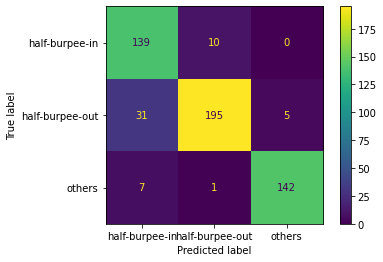

In [41]:
disp.plot()
plt.savefig(f'saved_artifacts/conf_matrix/final/{EXERCISE}/ViViT_cm.png', dpi=300)
plt.show()

### ROC AUC

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
roc_auc_score(raw_test_y, raw_preds_y)

0.9802181392324377

# Load model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
loaded_model = load_model(os.path.join(model_dir, f'{EXERCISE}_ViViT.h5'), custom_objects={"TubeletEmbedding": TubeletEmbedding, 
                                                                                      "PositionalEncoder": PositionalEncoder})

In [46]:
loaded_model.inputs

[<KerasTensor: shape=(None, 8, 120, 120, 3) dtype=float32 (created by layer 'input_1')>]

In [47]:
loaded_model.outputs

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_16')>]

# Detect in real time

In [48]:
# serialize model and le
with open(os.path.join(pickle_dir, f'{EXERCISE}_ViViT_le.pickle'), 'rb') as file:
    loaded_le = pickle.load(file)

In [49]:
from collections import deque, Counter

In [50]:
NUM_TEST_VIDS = 3
SEQ_LEN = 8
for i in range(1,1+NUM_TEST_VIDS):
    vid_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    rep_count = 0
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)
    video_writer = cv2.VideoWriter(os.path.join(output_vid_dir, f'{EXERCISE}_{i}_ViViT{SUBFIX_VID_NAME}.avi'), cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        image = cv2.resize(frame, (640, 360))
        image_input = cv2.resize(frame, (120, 120))

        vid_seq.append(image_input)

        if len(vid_seq) == SEQ_LEN:
            input_seq = np.array(vid_seq) / 255.0
            y_hat = loaded_model.predict(tf.expand_dims(input_seq, axis=0))[0]
            y_idx = np.argmax(y_hat)
            
            if 'hard_vote' in SUBFIX_VID_NAME:
                # do hard voting
                preds_window.append(y_idx)
                pred_count = Counter(preds_window)
                # most_common return .items() format
                # ex. [(0,5), (1,3)]
                voted_pred = pred_count.most_common(1)[0][0]
                class_name = loaded_le.classes_[voted_pred]
            else:
                class_name = loaded_le.classes_[y_idx]
                
            prob = np.max(y_hat)
            print(y_hat, class_name, prob, end='\r')
        else:
            class_name = "None"
            prob = 0

        # count the rep logic
        current_stage = class_name

        if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
            rep_count += 1

        previous_stage = current_stage

        print('rep:',rep_count, end='\r')

        
        # status box at top left corner
        cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

        # display class
        cv2.putText(image, 'Class', (95, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, class_name, (95, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # display prob
        cv2.putText(image, 'Prob', (15, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # rep count box at top right corner
        cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

        # display rep count
        cv2.putText(image, 'Rep', (640-52, 0+15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(rep_count), (640-52, 0+50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

        video_writer.write(image)
        if not REMOTE:
            cv2.imshow(f'{EXERCISE} Count Detection', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    video_writer.release()
    if not REMOTE:
        cv2.destroyAllWindows()

# Save class for visualization
only the best performing model

In [51]:
NUM_TEST_VIDS = 3
SEQ_LEN = 8
for i in range(1, 1+NUM_TEST_VIDS):
    vid_seq = deque(maxlen=SEQ_LEN)
    preds_window = deque(maxlen=15)
    predicted_class = []
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_size = (640, 360)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        image = cv2.resize(frame, (640, 360))
        image_input = cv2.resize(frame, (120, 120))

        vid_seq.append(image_input)
        
        if len(vid_seq) == SEQ_LEN:
            input_seq = np.array(vid_seq) / 255.0
            y_hat = loaded_model.predict(tf.expand_dims(input_seq, axis=0))[0]
            y_idx = np.argmax(y_hat)
            
            if 'hard_vote' in SUBFIX_VID_NAME:
                # do hard voting
                preds_window.append(y_idx)
                pred_count = Counter(preds_window)
                # most_common return .items() format
                # ex. [(0,5), (1,3)]
                voted_pred = pred_count.most_common(1)[0][0]
                class_name = loaded_le.classes_[voted_pred]
                predicted_class.append(voted_pred)
            else:
                class_name = loaded_le.classes_[y_idx]
                predicted_class.append(y_idx)
                        
            prob = np.max(y_hat)
            print(y_hat, class_name, prob, end='\r')
        else:
            predicted_class.append(0)
            class_name = "None"
            prob = 0

        # status box at top left corner
        cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

        # display class
        cv2.putText(image, 'Class', (95, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, class_name, (95, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # display prob
        cv2.putText(image, 'Prob', (15, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # rep count box at top right corner
        cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

        if not REMOTE:
            cv2.imshow(f'{EXERCISE} Count Detection', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
     
    temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/round_{ROUND}'
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path, exist_ok=True)
    with open(os.path.join(temp_save_path, f'test_vid_{i}_ViViT{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
        pickle.dump(predicted_class, f)
    cap.release()
    if not REMOTE:
        cv2.destroyAllWindows()